In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Ajuste para o seu caminho real (pelo log, você está usando "Artigo - Dados")
BASE_ANON = "/content/drive/MyDrive/Mestrado/Artigo - Dados/Dados_Anonimizados"
BASE_OUT  = "/content/drive/MyDrive/Mestrado/Artigo - Dados/Ataques_Resultados"

os.makedirs(BASE_OUT, exist_ok=True)

ANOS = [2018, 2019, 2020, 2021, 2022, 2023]

print("BASE_ANON:", BASE_ANON)
print("BASE_OUT :", BASE_OUT)

Mounted at /content/drive
BASE_ANON: /content/drive/MyDrive/Mestrado/Artigo - Dados/Dados_Anonimizados
BASE_OUT : /content/drive/MyDrive/Mestrado/Artigo - Dados/Ataques_Resultados


In [3]:
TECNICAS = {
    "original":           f"{BASE_ANON}/original",
    "permutacao":         f"{BASE_ANON}/permutacao",
    "generalizacao_dec1": f"{BASE_ANON}/generalizacao_dec1",
    "microagregacao_k5":  f"{BASE_ANON}/microagregacao_k5",
    "k_anon_k2":          f"{BASE_ANON}/k_anon_k2",
    "dp_eps_1.0":         f"{BASE_ANON}/dp/eps_1.0",
}

# Ataques:
# A1 NN-Linkage (1-para-1): aplicável quando cada registro mantém correspondência com o original
#    -> DP e permutação (mesmo número de linhas, mesmas linhas, só coords mudam).
# A2 Top-K Linkage: idem.
# A3 Ambiguidade espacial (candidate set): aplicável a TODAS.
# A4 k-anonimato efetivo / tamanho de classes: aplicável a generalização, microagregação e k-anon.
# A5 Reconstrução por média temporal: aplicável principalmente a DP (e pode ser explorado para permutação, mas é fraco).

APLICA = {
    "original":           {"A1": False, "A2": False, "A3": True, "A4": False, "A5": False},
    "permutacao":         {"A1": True,  "A2": True,  "A3": True, "A4": False, "A5": False},
    "generalizacao_dec1": {"A1": False, "A2": False, "A3": True, "A4": True,  "A5": False},
    "microagregacao_k5":  {"A1": False, "A2": False, "A3": True, "A4": True,  "A5": False},
    "k_anon_k2":          {"A1": False, "A2": False, "A3": True, "A4": True,  "A5": False},
    "dp_eps_1.0":         {"A1": True,  "A2": True,  "A3": True, "A4": False, "A5": True},
}

print("Técnicas:", list(TECNICAS.keys()))


Técnicas: ['original', 'permutacao', 'generalizacao_dec1', 'microagregacao_k5', 'k_anon_k2', 'dp_eps_1.0']


In [4]:
# Curva de vazamento
LEAK_RATES = [0.01, 0.05, 0.10]

# A1
RADIUS_LIST = (50, 100, 200)

# A2
TOPK_LIST = (3, 5, 10)
TOPK_RADIUS_M = 200

print("LEAK_RATES:", LEAK_RATES)
print("RADIUS_LIST:", RADIUS_LIST)
print("TOPK_LIST:", TOPK_LIST, "TOPK_RADIUS_M:", TOPK_RADIUS_M)


LEAK_RATES: [0.01, 0.05, 0.1]
RADIUS_LIST: (50, 100, 200)
TOPK_LIST: (3, 5, 10) TOPK_RADIUS_M: 200


In [5]:
from sklearn.neighbors import BallTree

def haversine_m(lat1, lon1, lat2, lon2):
    """Distância Haversine em metros."""
    R = 6371000.0
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R*c

def carregar_tecnica(pasta_tecnica, anos=ANOS):
    dfs = []

    for ano in anos:
        candidatos = glob.glob(os.path.join(pasta_tecnica, f"*{ano}*.csv"))

        if not candidatos:
            raise FileNotFoundError(
                f"❌ Não achei CSV do ano {ano} em: {pasta_tecnica}"
            )

        path = candidatos[0]  # pega o primeiro que casar
        df = pd.read_csv(path, low_memory=False, sep=",")
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

def preparar_df_coords(df):
    """
    Seleciona e limpa colunas mínimas:
    - latitude, longitude
    - inspection_realized_at (se existir) para reconstrução temporal
    """
    out = df.copy()

    if "inspection_realized_at" in out.columns:
        out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")

    out["latitude"] = pd.to_numeric(out["latitude"], errors="coerce")
    out["longitude"] = pd.to_numeric(out["longitude"], errors="coerce")
    out = out.dropna(subset=["latitude", "longitude"])

    # filtro geográfico (POA)
    out = out[
        out["latitude"].between(-30.20, -29.80) &
        out["longitude"].between(-51.35, -50.95)
    ].copy()

    return out

In [6]:
df_original_raw = carregar_tecnica(TECNICAS["original"])
df_original = preparar_df_coords(df_original_raw)

print("Original:", df_original.shape)
df_original[["latitude","longitude","inspection_realized_at"]].head()


Original: (292235, 159)


,latitude,longitude,inspection_realized_at
0,-30.066,-51.234,2018-09-03 11:47:00
1,-30.032,-51.112,2018-06-03 15:27:00
2,-30.009,-51.171,2018-07-03 07:37:00
3,-30.068,-51.175,2018-05-03 11:07:00
4,-30.066,-51.176,2018-05-03 11:27:00


In [7]:
def ataque_A1_nn_linkage(df_orig, df_anon, leak_rate=0.05, radius_m_list=(50, 100, 200), seed=42):
    """
    Linkage 1-NN assumindo correspondência por índice/linha (aplicável para DP e permutação
    quando o dataset mantém a mesma ordem e cardinalidade).
    """
    rng = np.random.default_rng(seed)

    n = min(len(df_orig), len(df_anon))
    df_o = df_orig.iloc[:n].copy()
    df_a = df_anon.iloc[:n].copy()

    # subconjunto conhecido pelo atacante
    m = max(1, int(n * float(leak_rate)))
    idx = rng.choice(np.arange(n), size=m, replace=False)

    orig_pts = np.deg2rad(df_o.iloc[idx][["latitude","longitude"]].values)
    anon_pts = np.deg2rad(df_a[["latitude","longitude"]].values)

    tree = BallTree(anon_pts, metric="haversine")

    dist_rad, ind = tree.query(orig_pts, k=1)
    dist_m = dist_rad[:, 0] * 6371000.0
    nn_idx = ind[:, 0]

    out = []
    for r in radius_m_list:
        ok = ((nn_idx == idx) & (dist_m <= r)).mean()
        out.append({"leak_rate": float(leak_rate), "radius_m": r, "reid_rate": float(ok), "n_leaked": int(m)})

    return pd.DataFrame(out)

In [8]:
def ataque_A2_topk(df_orig, df_anon, leak_rate=0.05, k_list=(3,5,10), radius_m=200, seed=42):
    """
    Linkage Top-K: sucesso se o índice verdadeiro aparece no top-k dentro do raio.
    """
    rng = np.random.default_rng(seed)

    n = min(len(df_orig), len(df_anon))
    df_o = df_orig.iloc[:n].copy()
    df_a = df_anon.iloc[:n].copy()

    m = max(1, int(n * float(leak_rate)))
    idx = rng.choice(np.arange(n), size=m, replace=False)

    orig_pts = np.deg2rad(df_o.iloc[idx][["latitude","longitude"]].values)
    anon_pts = np.deg2rad(df_a[["latitude","longitude"]].values)

    tree = BallTree(anon_pts, metric="haversine")

    out = []
    for k in k_list:
        dist_rad, ind = tree.query(orig_pts, k=k)
        dist_m = dist_rad * 6371000.0

        hit = []
        for i, true_idx in enumerate(idx):
            candidates = ind[i]
            within = dist_m[i] <= radius_m
            ok = (true_idx in candidates[within])
            hit.append(ok)

        out.append({
            "leak_rate": float(leak_rate),
            "topk": int(k),
            "radius_m": float(radius_m),
            "hit_rate": float(np.mean(hit)),
            "n_leaked": int(m)
        })

    return pd.DataFrame(out)


In [9]:
def ataque_A3_ambiguidade(df_orig, df_anon, radius_m_list=(50,100,200,500)):
    orig_pts = np.deg2rad(df_orig[["latitude","longitude"]].values)
    anon_pts = np.deg2rad(df_anon[["latitude","longitude"]].values)

    tree = BallTree(anon_pts, metric="haversine")

    out = []
    for r in radius_m_list:
        r_rad = r / 6371000.0
        counts = tree.query_radius(orig_pts, r=r_rad, count_only=True)

        out.append({
            "radius_m": r,
            "avg_candidates": float(np.mean(counts)),
            "median_candidates": float(np.median(counts)),
            "pct_unique_candidate": float(np.mean(counts == 1)),
            "pct_zero_candidate": float(np.mean(counts == 0)),
        })
    return pd.DataFrame(out)


In [10]:
def ataque_A4_classes_equivalencia(df_anon):
    # classes por coordenada exata (após anonimização)
    grp = df_anon.groupby(["latitude","longitude"]).size().reset_index(name="class_size")

    return {
        "n_classes": int(len(grp)),
        "avg_class_size": float(grp["class_size"].mean()),
        "median_class_size": float(grp["class_size"].median()),
        "min_class_size": int(grp["class_size"].min()),
        "pct_classes_ge_2": float((grp["class_size"] >= 2).mean()),
        "pct_classes_ge_5": float((grp["class_size"] >= 5).mean()),
    }


In [11]:
def ataque_A5_media_temporal(df_anon, decimals_group=3):
    if "inspection_realized_at" not in df_anon.columns:
        return None

    d = df_anon.dropna(subset=["inspection_realized_at"]).copy()
    d["lat_g"] = d["latitude"].round(decimals_group)
    d["lon_g"] = d["longitude"].round(decimals_group)

    # Grupos com repetição
    grp = d.groupby(["lat_g","lon_g"]).agg(
        n_obs=("latitude","size"),
        lat_mean=("latitude","mean"),
        lon_mean=("longitude","mean"),
        lat_std=("latitude","std"),
        lon_std=("longitude","std")
    ).reset_index()

    # foco em grupos realmente repetidos
    grp_rep = grp[grp["n_obs"] >= 5].copy()
    if grp_rep.empty:
        return {"n_groups_rep_ge5": 0}

    return {
        "n_groups_rep_ge5": int(len(grp_rep)),
        "avg_n_obs": float(grp_rep["n_obs"].mean()),
        "avg_lat_std": float(grp_rep["lat_std"].fillna(0).mean()),
        "avg_lon_std": float(grp_rep["lon_std"].fillna(0).mean()),
    }


In [12]:
RESULTS = []

A1_all, A2_all, A3_all, A4_all, A5_all = [], [], [], [], []

for tecnica, path in TECNICAS.items():
    print("\n==============================")
    print("Técnica:", tecnica)
    print("Path   :", path)
    print("==============================")

    df_anon_raw = carregar_tecnica(path)
    df_anon = preparar_df_coords(df_anon_raw)

    out_dir = os.path.join(BASE_OUT, tecnica)
    os.makedirs(out_dir, exist_ok=True)

    # A3 (universal)
    if APLICA[tecnica]["A3"]:
        df_a3 = ataque_A3_ambiguidade(df_original, df_anon)
        df_a3["tecnica"] = tecnica
        df_a3.to_csv(os.path.join(out_dir, "A3_ambiguidade.csv"), index=False)
        A3_all.append(df_a3)
        print("✅ A3 salvo")

    # A1 (curva)
    if APLICA[tecnica]["A1"]:
        dfs = []
        for lr in LEAK_RATES:
            df_a1 = ataque_A1_nn_linkage(df_original, df_anon, leak_rate=lr, radius_m_list=RADIUS_LIST)
            df_a1["tecnica"] = tecnica
            dfs.append(df_a1)
        df_a1_all = pd.concat(dfs, ignore_index=True)
        df_a1_all.to_csv(os.path.join(out_dir, "A1_nn_linkage_curve.csv"), index=False)
        A1_all.append(df_a1_all)
        print("✅ A1 curva salva")

    # A2 (curva)
    if APLICA[tecnica]["A2"]:
        dfs = []
        for lr in LEAK_RATES:
            df_a2 = ataque_A2_topk(df_original, df_anon, leak_rate=lr, k_list=TOPK_LIST, radius_m=TOPK_RADIUS_M)
            df_a2["tecnica"] = tecnica
            dfs.append(df_a2)
        df_a2_all = pd.concat(dfs, ignore_index=True)
        df_a2_all.to_csv(os.path.join(out_dir, "A2_topk_curve.csv"), index=False)
        A2_all.append(df_a2_all)
        print("✅ A2 curva salva")

    # A4 (classes)
    if APLICA[tecnica]["A4"]:
        a4 = ataque_A4_classes_equivalencia(df_anon)
        df_a4 = pd.DataFrame([a4])
        df_a4["tecnica"] = tecnica
        df_a4.to_csv(os.path.join(out_dir, "A4_classes_equivalencia.csv"), index=False)
        A4_all.append(df_a4)
        print("✅ A4 salvo")

    # A5 (DP)
    if APLICA[tecnica]["A5"]:
        a5 = ataque_A5_media_temporal(df_anon)
        if a5 is not None:
            df_a5 = pd.DataFrame([a5])
            df_a5["tecnica"] = tecnica
            df_a5.to_csv(os.path.join(out_dir, "A5_media_temporal.csv"), index=False)
            A5_all.append(df_a5)
            print("✅ A5 salvo")

    RESULTS.append({"tecnica": tecnica, "n_original": len(df_original), "n_anon": len(df_anon)})

# Consolidados globais
pd.DataFrame(RESULTS).to_csv(os.path.join(BASE_OUT, "resumo_execucao.csv"), index=False)

if A1_all: pd.concat(A1_all, ignore_index=True).to_csv(os.path.join(BASE_OUT, "A1_nn_linkage_curve_todas.csv"), index=False)
if A2_all: pd.concat(A2_all, ignore_index=True).to_csv(os.path.join(BASE_OUT, "A2_topk_curve_todas.csv"), index=False)
if A3_all: pd.concat(A3_all, ignore_index=True).to_csv(os.path.join(BASE_OUT, "A3_ambiguidade_todas.csv"), index=False)
if A4_all: pd.concat(A4_all, ignore_index=True).to_csv(os.path.join(BASE_OUT, "A4_classes_todas.csv"), index=False)
if A5_all: pd.concat(A5_all, ignore_index=True).to_csv(os.path.join(BASE_OUT, "A5_media_temporal_todas.csv"), index=False)

print("\n✅ Finalizado. Resultados em:", BASE_OUT)



Técnica: original
Path   : /content/drive/MyDrive/Mestrado/Artigo - Dados/Dados_Anonimizados/original
✅ A3 salvo

Técnica: permutacao
Path   : /content/drive/MyDrive/Mestrado/Artigo - Dados/Dados_Anonimizados/permutacao
✅ A3 salvo
✅ A1 curva salva
✅ A2 curva salva

Técnica: generalizacao_dec1
Path   : /content/drive/MyDrive/Mestrado/Artigo - Dados/Dados_Anonimizados/generalizacao_dec1
✅ A3 salvo
✅ A4 salvo

Técnica: microagregacao_k5
Path   : /content/drive/MyDrive/Mestrado/Artigo - Dados/Dados_Anonimizados/microagregacao_k5


/tmp/ipython-input-3496788248.py:39: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")


✅ A3 salvo
✅ A4 salvo

Técnica: k_anon_k2
Path   : /content/drive/MyDrive/Mestrado/Artigo - Dados/Dados_Anonimizados/k_anon_k2


/tmp/ipython-input-3496788248.py:39: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")


✅ A3 salvo
✅ A4 salvo

Técnica: dp_eps_1.0
Path   : /content/drive/MyDrive/Mestrado/Artigo - Dados/Dados_Anonimizados/dp/eps_1.0
✅ A3 salvo
✅ A1 curva salva
✅ A2 curva salva
✅ A5 salvo

✅ Finalizado. Resultados em: /content/drive/MyDrive/Mestrado/Artigo - Dados/Ataques_Resultados


In [13]:
all_rows = []

for tecnica in TECNICAS.keys():
    p = os.path.join(BASE_OUT, tecnica, "A3_ambiguidade.csv")
    if os.path.exists(p):
        df = pd.read_csv(p)
        df["tecnica"] = tecnica
        all_rows.append(df)

df_A3_all = pd.concat(all_rows, ignore_index=True)
display(df_A3_all.head())

out_path = os.path.join(BASE_OUT, "A3_ambiguidade_todas_tecnicas.csv")
df_A3_all.to_csv(out_path, index=False)
print("✅ Consolidado A3 salvo:", out_path)


,radius_m,avg_candidates,median_candidates,pct_unique_candidate,pct_zero_candidate,tecnica
0,50,175.413804,188.0,0.000068,0.000000,original
1,100,193.116803,214.0,0.000031,0.000000,original
2,200,343.032488,309.0,0.000007,0.000000,original
3,500,2246.064458,2264.0,0.000003,0.000000,original
4,50,19.165873,18.0,0.022786,0.014252,permutacao


✅ Consolidado A3 salvo: /content/drive/MyDrive/Mestrado/Artigo - Dados/Ataques_Resultados/A3_ambiguidade_todas_tecnicas.csv


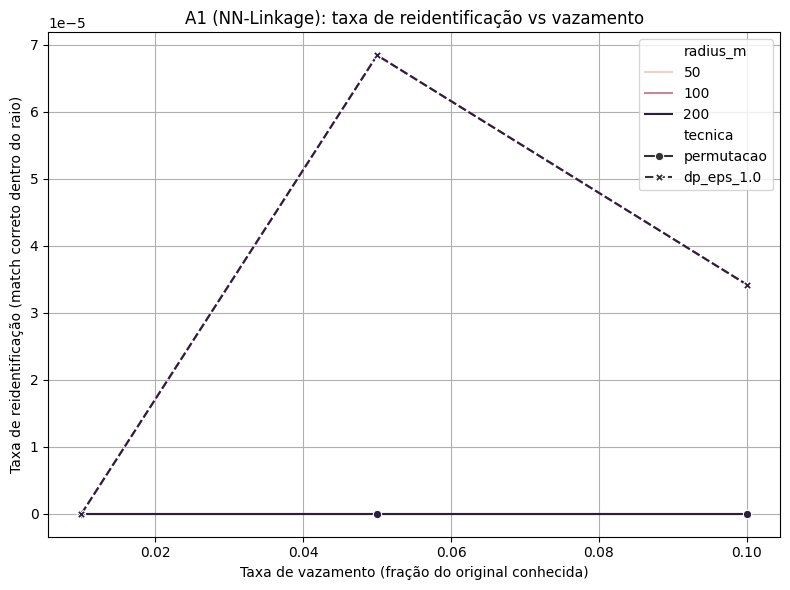

✅ Salvo: /content/drive/MyDrive/Mestrado/Artigo - Dados/Ataques_Resultados/plot_A1_curve.png


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

path_a1 = os.path.join(BASE_OUT, "A1_nn_linkage_curve_todas.csv")
if os.path.exists(path_a1):
    df_a1 = pd.read_csv(path_a1)

    plt.figure(figsize=(8,6))
    sns.lineplot(data=df_a1, x="leak_rate", y="reid_rate", hue="radius_m", style="tecnica", markers=True)
    plt.title("A1 (NN-Linkage): taxa de reidentificação vs vazamento")
    plt.xlabel("Taxa de vazamento (fração do original conhecida)")
    plt.ylabel("Taxa de reidentificação (match correto dentro do raio)")
    plt.grid(True)
    plt.tight_layout()

    out_png = os.path.join(BASE_OUT, "plot_A1_curve.png")
    plt.savefig(out_png, dpi=250)
    plt.show()
    print("✅ Salvo:", out_png)
else:
    print("A1 consolidado não encontrado:", path_a1)


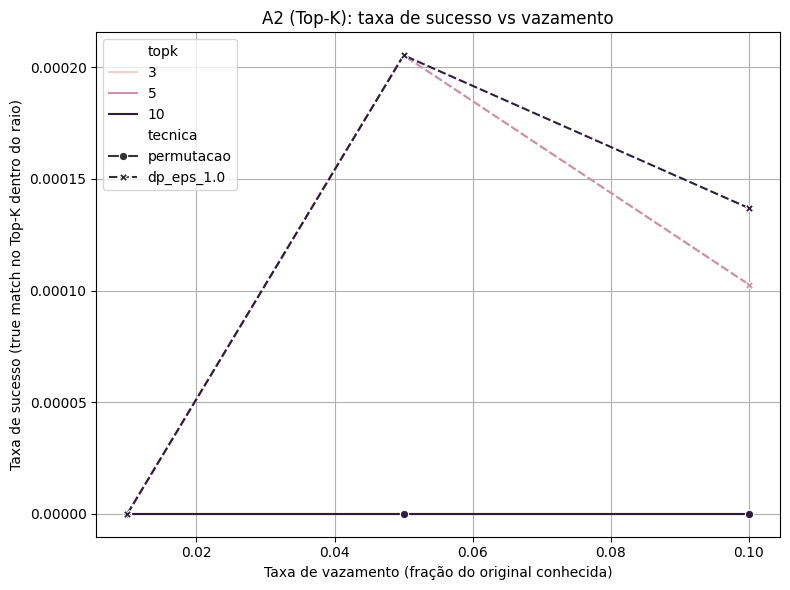

✅ Salvo: /content/drive/MyDrive/Mestrado/Artigo - Dados/Ataques_Resultados/plot_A2_curve.png


In [15]:
path_a2 = os.path.join(BASE_OUT, "A2_topk_curve_todas.csv")
if os.path.exists(path_a2):
    df_a2 = pd.read_csv(path_a2)

    plt.figure(figsize=(8,6))
    sns.lineplot(data=df_a2, x="leak_rate", y="hit_rate", hue="topk", style="tecnica", markers=True)
    plt.title("A2 (Top-K): taxa de sucesso vs vazamento")
    plt.xlabel("Taxa de vazamento (fração do original conhecida)")
    plt.ylabel("Taxa de sucesso (true match no Top-K dentro do raio)")
    plt.grid(True)
    plt.tight_layout()

    out_png = os.path.join(BASE_OUT, "plot_A2_curve.png")
    plt.savefig(out_png, dpi=250)
    plt.show()
    print("✅ Salvo:", out_png)
else:
    print("A2 consolidado não encontrado:", path_a2)


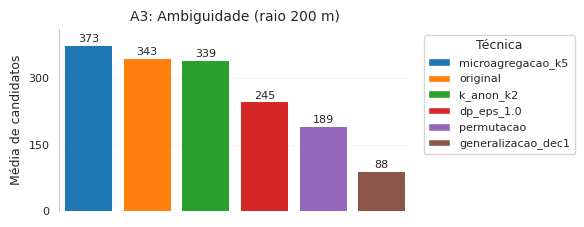

✅ Salvo: /content/drive/MyDrive/Mestrado/Artigo - Dados/figures/plot_A3_ambiguidade_compacto.png


In [2]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os
# from matplotlib.ticker import MaxNLocator
# from matplotlib.patches import Patch

# A3_PATH = "/content/drive/MyDrive/Mestrado/Artigo - Dados/Ataques_Resultados/A3_ambiguidade_todas_tecnicas.csv"
# OUT_FIG_DIR = "/content/drive/MyDrive/Mestrado/Artigo - Dados/figures"
# os.makedirs(OUT_FIG_DIR, exist_ok=True)

# df = pd.read_csv(A3_PATH)

# RAIO = 200
# d = df[df["radius_m"] == RAIO].copy()
# d = d.sort_values("avg_candidates", ascending=False)

# order = d["tecnica"].tolist()
# colors = sns.color_palette("tab10", n_colors=len(order))
# palette = dict(zip(order, colors))

# fig, ax = plt.subplots(figsize=(6, 2.4))

# # 1) plota SEM hue (evita bug/limitação da legenda)
# sns.barplot(
#     data=d,
#     x="tecnica",
#     y="avg_candidates",
#     order=order,
#     color="lightgray",   # cor temporária; vamos sobrescrever
#     ax=ax
# )

# # 2) aplica uma cor por barra
# for bar, tech in zip(ax.patches, order):
#     bar.set_facecolor(palette[tech])
#     bar.set_edgecolor("none")

# # 3) legenda manual (sempre funciona)
# handles = [Patch(facecolor=palette[t], label=t) for t in order]
# ax.legend(
#     handles=handles,
#     title="Técnica",
#     fontsize=8,
#     title_fontsize=9,
#     loc="upper left",
#     bbox_to_anchor=(1.02, 1),
#     frameon=True,
#     ncol=1  # mude para 2 se quiser legenda mais “baixa”
# )

# # --- compactação visual ---
# ax.set_title(f"A3: Ambiguidade (raio {RAIO} m)", fontsize=10)
# ax.set_xlabel("")
# ax.set_ylabel("Média de candidatos", fontsize=9)

# # remove rótulos do eixo x (ficam na legenda)
# ax.set_xticklabels([])
# ax.tick_params(axis="x", length=0)

# # eixo Y mais limpo
# ax.yaxis.set_major_locator(MaxNLocator(4))
# ax.tick_params(axis="y", labelsize=8)

# # limite superior justo
# ymax = d["avg_candidates"].max()
# ax.set_ylim(0, ymax * 1.10)

# ax.grid(axis="y", alpha=0.25)
# ax.grid(axis="x", visible=False)
# sns.despine(ax=ax, left=False, bottom=True)

# out_path = os.path.join(OUT_FIG_DIR, "plot_A3_ambiguidade_compacto.png")
# plt.tight_layout()
# plt.savefig(out_path, dpi=300, bbox_inches="tight")
# plt.show()
# print("✅ Salvo:", out_path)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch

A3_PATH = "/content/drive/MyDrive/Mestrado/Artigo - Dados/Ataques_Resultados/A3_ambiguidade_todas_tecnicas.csv"
OUT_FIG_DIR = "/content/drive/MyDrive/Mestrado/Artigo - Dados/figures"
os.makedirs(OUT_FIG_DIR, exist_ok=True)

df = pd.read_csv(A3_PATH)

RAIO = 200
d = df[df["radius_m"] == RAIO].copy()
d = d.sort_values("avg_candidates", ascending=False)

order = d["tecnica"].tolist()
colors = sns.color_palette("tab10", n_colors=len(order))
palette = dict(zip(order, colors))

# =========================
# FUNÇÃO PARA RÓTULOS NO TOPO DAS BARRAS
# =========================
def rotular_barras_topo(ax, fmt="{:.0f}", dy=0.01, fontsize=8):
    """
    Adiciona rótulos no topo das barras.
    dy = deslocamento relativo ao eixo Y (ex: 1%)
    """
    ymax = ax.get_ylim()[1]

    for bar in ax.patches:
        h = bar.get_height()
        if h <= 0:
            continue

        ax.text(
            bar.get_x() + bar.get_width() / 2,
            h + ymax * dy,
            fmt.format(h),
            ha="center",
            va="bottom",
            fontsize=fontsize
        )

# =========================
# PLOT
# =========================
fig, ax = plt.subplots(figsize=(6, 2.4))

# 1) plota SEM hue (evita bug/limitação da legenda)
sns.barplot(
    data=d,
    x="tecnica",
    y="avg_candidates",
    order=order,
    color="lightgray",   # cor temporária; vamos sobrescrever
    ax=ax
)

# 2) aplica uma cor por barra
for bar, tech in zip(ax.patches, order):
    bar.set_facecolor(palette[tech])
    bar.set_edgecolor("none")

# 3) legenda manual (sempre funciona)
handles = [Patch(facecolor=palette[t], label=t) for t in order]
ax.legend(
    handles=handles,
    title="Técnica",
    fontsize=8,
    title_fontsize=9,
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    frameon=True,
    ncol=1
)

# --- compactação visual ---
ax.set_title(f"A3: Ambiguidade (raio {RAIO} m)", fontsize=10)
ax.set_xlabel("")
ax.set_ylabel("Média de candidatos", fontsize=9)

# remove rótulos do eixo x (ficam na legenda)
ax.set_xticklabels([])
ax.tick_params(axis="x", length=0)

# eixo Y mais limpo
ax.yaxis.set_major_locator(MaxNLocator(4))
ax.tick_params(axis="y", labelsize=8)

# limite superior justo (IMPORTANTE: antes dos rótulos)
ymax = d["avg_candidates"].max()
ax.set_ylim(0, ymax * 1.10)

# >>> RÓTULOS DE DADOS NO TOPO DAS BARRAS <<<
rotular_barras_topo(
    ax,
    fmt="{:.0f}",   # inteiro
    dy=0.01,        # 1% acima da barra
    fontsize=8
)

# grade e estética
ax.grid(axis="y", alpha=0.25)
ax.grid(axis="x", visible=False)
sns.despine(ax=ax, left=False, bottom=True)

# salvar
out_path = os.path.join(OUT_FIG_DIR, "plot_A3_ambiguidade_compacto.png")
plt.tight_layout()
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Salvo:", out_path)



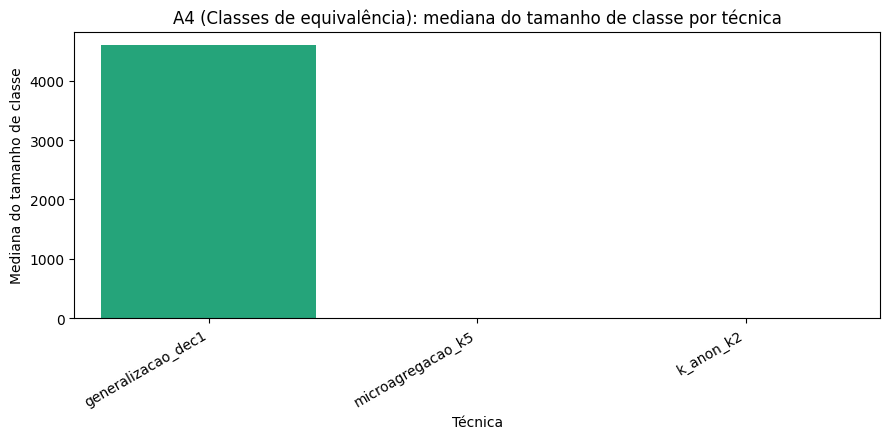

✅ Salvo: /content/drive/MyDrive/Mestrado/Artigo - Dados/figures/plot_A4_classes.png


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

A4_PATH = "/content/drive/MyDrive/Mestrado/Artigo - Dados/Ataques_Resultados/A4_classes_todas.csv"
OUT_FIG_DIR = "/content/drive/MyDrive/Mestrado/Artigo - Dados/figures"
os.makedirs(OUT_FIG_DIR, exist_ok=True)

df = pd.read_csv(A4_PATH)

# A4 só existe para técnicas aplicáveis; vamos ordenar pela mediana
df = df.sort_values("median_class_size", ascending=False)

plt.figure(figsize=(9,4.5))
sns.barplot(data=df, x="tecnica", y="median_class_size", color="#10b981")
plt.xticks(rotation=30, ha="right")
plt.title("A4 (Classes de equivalência): mediana do tamanho de classe por técnica")
plt.xlabel("Técnica")
plt.ylabel("Mediana do tamanho de classe")
plt.tight_layout()

out_path = os.path.join(OUT_FIG_DIR, "plot_A4_classes.png")
plt.savefig(out_path, dpi=250)
plt.show()
print("✅ Salvo:", out_path)


In [18]:
def plot_mapa(df, titulo, out_path=None, sample=None):
    """
    df: DataFrame com latitude e longitude
    sample: int ou None (para amostragem, se quiser)
    """
    if sample:
        df = df.sample(sample, random_state=42)

    plt.figure(figsize=(5, 5))
    plt.scatter(
        df["longitude"],
        df["latitude"],
        s=3,
        alpha=0.4
    )
    plt.title(titulo)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.tight_layout()

    if out_path:
        plt.savefig(out_path, dpi=250)
    plt.show()


/tmp/ipython-input-3496788248.py:39: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")
/tmp/ipython-input-3496788248.py:39: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")


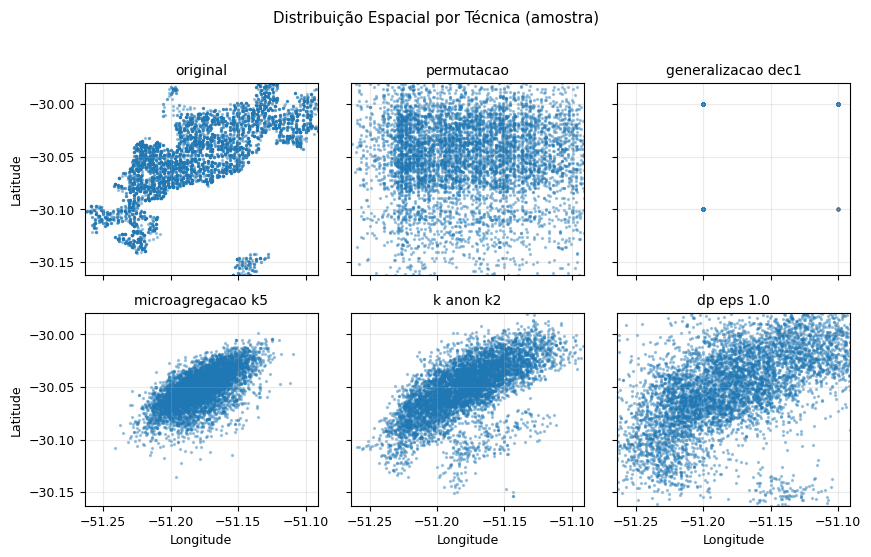

✅ Salvo em: /content/drive/MyDrive/Mestrado/Artigo - Dados/figures/mapas_3x2_tecnicas.png


In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt

OUT_FIG = "/content/drive/MyDrive/Mestrado/Artigo - Dados/figures"
os.makedirs(OUT_FIG, exist_ok=True)

# 6 mapas (ordem 3x2)
TECNICAS_6 = [
    ("original", TECNICAS["original"]),
    ("permutacao", TECNICAS["permutacao"]),
    ("generalizacao_dec1", TECNICAS["generalizacao_dec1"]),
    ("microagregacao_k5", TECNICAS["microagregacao_k5"]),
    ("k_anon_k2", TECNICAS["k_anon_k2"]),
    ("dp_eps_1.0", TECNICAS["dp_eps_1.0"]),
]

# --- Carrega tudo e padroniza limites (para comparabilidade)
dfs = {}
for nome, path in TECNICAS_6:
    df_raw = carregar_tecnica(path)
    df = preparar_df_coords(df_raw)
    dfs[nome] = df

# limites globais (mesmo "zoom" para todos)
all_lon = np.concatenate([dfs[k]["longitude"].values for k in dfs])
all_lat = np.concatenate([dfs[k]["latitude"].values for k in dfs])

xmin, xmax = np.nanpercentile(all_lon, [0.5, 99.5])
ymin, ymax = np.nanpercentile(all_lat, [0.5, 99.5])

# --- Plot (formato artigo)
plt.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 10,
    "axes.labelsize": 9
})

fig, axes = plt.subplots(2, 3, figsize=(8.8, 5.4), sharex=True, sharey=True)
axes = axes.ravel()

SAMPLE = 6000  # ajuste se quiser; 6000 costuma ficar bom no paper
for ax, (nome, _) in zip(axes, TECNICAS_6):
    df = dfs[nome]
    if len(df) > SAMPLE:
        df = df.sample(SAMPLE, random_state=42)

    ax.scatter(df["longitude"], df["latitude"], s=2, alpha=0.35)
    ax.set_title(nome.replace("_", " "))
    ax.grid(True, alpha=0.25)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

# rótulos só nas bordas (fica limpo para artigo)
for ax in axes[3:]:
    ax.set_xlabel("Longitude")
for ax in axes[0::3]:
    ax.set_ylabel("Latitude")

fig.suptitle("Distribuição Espacial por Técnica (amostra)", y=1.02)
fig.tight_layout()

out_path = f"{OUT_FIG}/mapas_3x2_tecnicas.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Salvo em:", out_path)


/tmp/ipython-input-705329790.py:104: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")
/tmp/ipython-input-705329790.py:104: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")
/tmp/ipython-input-4132256933.py:273: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 0.95])


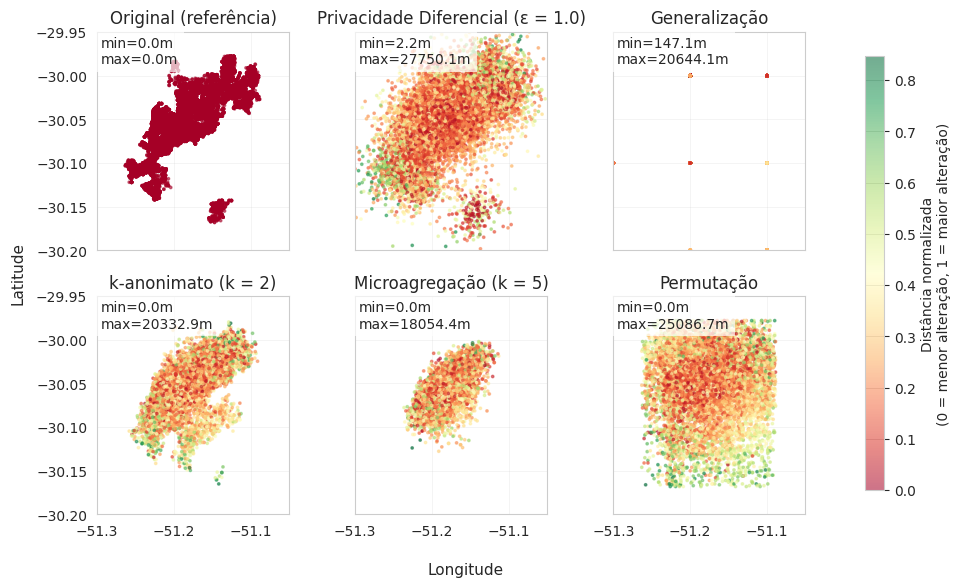

✅ Figura salva em: /content/drive/MyDrive/Mestrado/Artigo - Dados/figures/mapa_calor_dist_norm_3x2.png


In [57]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os

# OUT_FIG = "/content/drive/MyDrive/Mestrado/Artigo - Dados/figures"
# os.makedirs(OUT_FIG, exist_ok=True)

# mapas = [
#     ("original", "Original (referência)"),
#     ("dp_eps_1.0", "Privacidade Diferencial (ε = 1.0)"),
#     ("generalizacao_dec1", "Generalização"),
#     ("k_anon_k2", "k-anonimato (k = 2)"),
#     ("microagregacao_k5", "Microagregação (k = 5)"),
#     ("permutacao", "Permutação"),
# ]

# # limites fixos (para comparabilidade visual)
# lat_min, lat_max = -30.20, -29.95
# lon_min, lon_max = -51.30, -51.05

# SAMPLE = 12000
# rng = np.random.default_rng(42)

# # Haversine vetorizado (metros)
# def haversine_m(lat1, lon1, lat2, lon2):
#     R = 6371000.0
#     lat1 = np.deg2rad(lat1); lon1 = np.deg2rad(lon1)
#     lat2 = np.deg2rad(lat2); lon2 = np.deg2rad(lon2)
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
#     a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
#     c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
#     return R*c

# def dist_norm_por_tecnica(df_orig, df_anon):
#     """
#     Distância por linha (correspondência por índice) e normalização min-max por técnica.
#     Retorna: d_norm, d_min, d_max, n
#     """
#     n = min(len(df_orig), len(df_anon))
#     o = df_orig.iloc[:n][["latitude","longitude"]].to_numpy()
#     a = df_anon.iloc[:n][["latitude","longitude"]].to_numpy()

#     d = haversine_m(o[:,0], o[:,1], a[:,0], a[:,1])  # metros
#     d_min = float(np.min(d))
#     d_max = float(np.max(d))
#     if d_max == d_min:
#         d_norm = np.zeros_like(d, dtype=float)
#     else:
#         d_norm = (d - d_min) / (d_max - d_min)
#     return d_norm, d_min, d_max, n

# fig, axes = plt.subplots(2, 3, figsize=(9.5, 6.2), sharex=True, sharey=True)

# for ax, (tecnica, titulo) in zip(axes.flatten(), mapas):

#     if tecnica == "original":
#         df = df_original.copy()
#         # distância 0 para todos no original (referência)
#         n = len(df)
#         d_norm = np.zeros(n, dtype=float)
#         d_min, d_max = 0.0, 0.0
#     else:
#         df_raw = carregar_tecnica(TECNICAS[tecnica])
#         df = preparar_df_coords(df_raw)

#         d_norm, d_min, d_max, n = dist_norm_por_tecnica(df_original, df)
#         df = df.iloc[:n].copy()

#     # amostragem consistente
#     if len(df) > SAMPLE:
#         idx = rng.choice(len(df), size=SAMPLE, replace=False)
#         df_plot = df.iloc[idx]
#         c = d_norm[idx]
#     else:
#         df_plot = df
#         c = d_norm

#     sc = ax.scatter(
#         df_plot["longitude"],
#         df_plot["latitude"],
#         c=c,
#         s=3,
#         alpha=0.55,
#         cmap="RdYlGn"  # 0=vermelho, 1=verde
#     )

#     ax.set_title(titulo, fontsize=10)
#     ax.set_xlim(lon_min, lon_max)
#     ax.set_ylim(lat_min, lat_max)
#     ax.grid(True, alpha=0.3)

#     # resumo no canto: min/max em metros
#     ax.text(
#         0.02, 0.98,
#         f"min={d_min:.1f}m\nmax={d_max:.1f}m",
#         transform=ax.transAxes,
#         va="top", ha="left",
#         fontsize=8,
#         bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
#     )

# fig.supxlabel("Longitude", fontsize=11)
# fig.supylabel("Latitude", fontsize=11)
# plt.suptitle("Mapa de Calor da Alteração Espacial (distância normalizada 0–1)", fontsize=12, y=0.98)

# # Colorbar única (escala global 0-1)
# # cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), shrink=0.9, pad=0.02)
# # cbar.set_label("Distância normalizada (0=menor alteração, 1=maior alteração)")
# cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# # [left, bottom, width, height] em fração da figura

# cbar = fig.colorbar(sc, cax=cax)
# cbar.set_label(
#     "Distância normalizada\n(0 = menor alteração, 1 = maior alteração)",
#     fontsize=10
# )

# plt.tight_layout(rect=[0, 0, 0.90, 0.95])

# out_path = f"{OUT_FIG}/mapa_calor_dist_norm_3x2.png"
# plt.savefig(out_path, dpi=300)
# plt.show()

# print("✅ Figura salva em:", out_path)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

OUT_FIG = "/content/drive/MyDrive/Mestrado/Artigo - Dados/figures"
os.makedirs(OUT_FIG, exist_ok=True)

mapas = [
    ("original", "Original (referência)"),
    ("dp_eps_1.0", "Privacidade Diferencial (ε = 1.0)"),
    ("generalizacao_dec1", "Generalização"),
    ("k_anon_k2", "k-anonimato (k = 2)"),
    ("microagregacao_k5", "Microagregação (k = 5)"),
    ("permutacao", "Permutação"),
]

# limites fixos (para comparabilidade visual)
lat_min, lat_max = -30.20, -29.95
lon_min, lon_max = -51.30, -51.05

SAMPLE = 12000
rng = np.random.default_rng(42)

# -----------------------------
# Funções auxiliares (inalteradas)
# -----------------------------
def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0
    lat1 = np.deg2rad(lat1); lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2); lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R*c

def dist_norm_por_tecnica(df_orig, df_anon):
    """
    Distância por linha (correspondência por índice) e normalização min-max por técnica.
    Retorna: d_norm, d_min, d_max, n
    """
    n = min(len(df_orig), len(df_anon))
    o = df_orig.iloc[:n][["latitude","longitude"]].to_numpy()
    a = df_anon.iloc[:n][["latitude","longitude"]].to_numpy()

    d = haversine_m(o[:,0], o[:,1], a[:,0], a[:,1])
    d_min = float(np.min(d))
    d_max = float(np.max(d))

    if d_max == d_min:
        d_norm = np.zeros_like(d, dtype=float)
    else:
        d_norm = (d - d_min) / (d_max - d_min)

    return d_norm, d_min, d_max, n


# =========================================================
# AJUSTE DE FONTE (MESMO PADRÃO DO TRADE-OFF)
# =========================================================
rc_font = {
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
}

with mpl.rc_context(rc_font):

    fig, axes = plt.subplots(
        2, 3,
        figsize=(9.5, 6.2),
        sharex=True,
        sharey=True
    )

    for ax, (tecnica, titulo) in zip(axes.flatten(), mapas):

        if tecnica == "original":
            df = df_original.copy()
            n = len(df)
            d_norm = np.zeros(n, dtype=float)
            d_min, d_max = 0.0, 0.0
        else:
            df_raw = carregar_tecnica(TECNICAS[tecnica])
            df = preparar_df_coords(df_raw)

            d_norm, d_min, d_max, n = dist_norm_por_tecnica(df_original, df)
            df = df.iloc[:n].copy()

        # amostragem consistente
        if len(df) > SAMPLE:
            idx = rng.choice(len(df), size=SAMPLE, replace=False)
            df_plot = df.iloc[idx]
            c = d_norm[idx]
        else:
            df_plot = df
            c = d_norm

        sc = ax.scatter(
            df_plot["longitude"],
            df_plot["latitude"],
            c=c,
            s=3,
            alpha=0.55,
            cmap="RdYlGn"  # 0=vermelho, 1=verde
        )

        ax.set_title(titulo, fontsize=12)
        ax.set_xlim(lon_min, lon_max)
        ax.set_ylim(lat_min, lat_max)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis="both", labelsize=10)

        # resumo no canto: min/max em metros
        ax.text(
            0.02, 0.98,
            f"min={d_min:.1f}m\nmax={d_max:.1f}m",
            transform=ax.transAxes,
            va="top",
            ha="left",
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
        )

    fig.supxlabel("Longitude", fontsize=11)
    fig.supylabel("Latitude", fontsize=11)

    # plt.suptitle(
    #     "Mapa de Calor da Alteração Espacial (distância normalizada 0–1)",
    #     fontsize=12,
    #     y=0.98
    # )

    # Colorbar única (layout original preservado)
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc, cax=cax)
    cbar.set_label(
        "Distância normalizada\n(0 = menor alteração, 1 = maior alteração)",
        fontsize=10
    )
    cbar.ax.tick_params(labelsize=10)

    plt.tight_layout(rect=[0, 0, 0.90, 0.95])

    out_path = f"{OUT_FIG}/mapa_calor_dist_norm_3x2.png"
    plt.savefig(out_path, dpi=300)
    plt.show()

    print("✅ Figura salva em:", out_path)


/tmp/ipython-input-705329790.py:104: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")
/tmp/ipython-input-705329790.py:104: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")


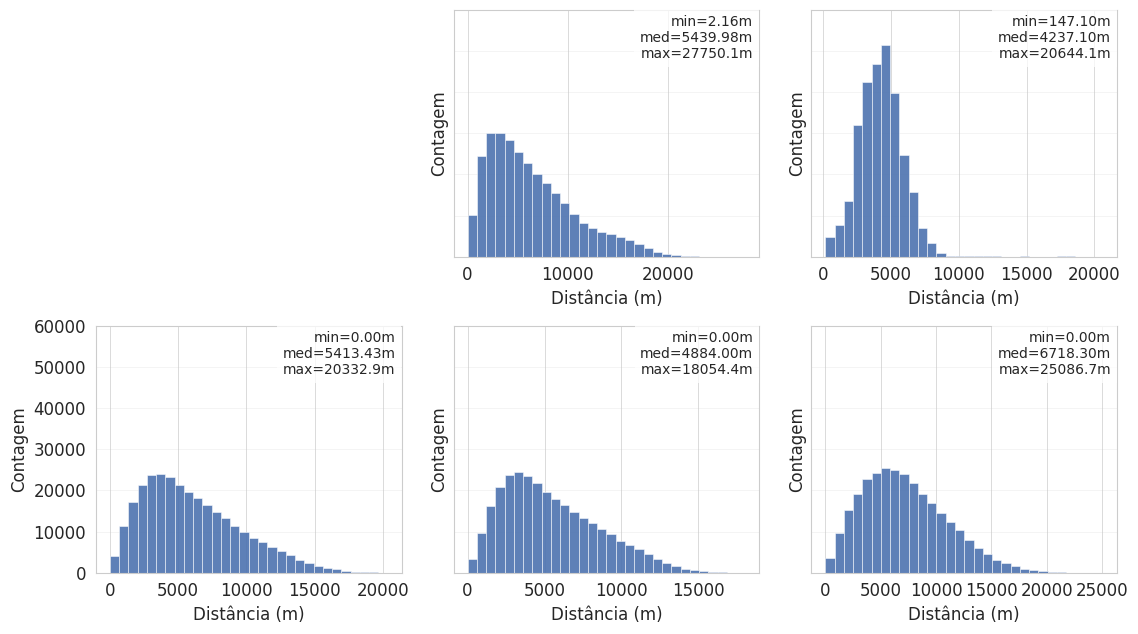

✅ Figura salva em: /content/drive/MyDrive/Mestrado/Artigo - Dados/figures/hist_dist_uniforme_30bins_mesma_escalaY.png
Y máximo global: 60000


In [59]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# import math

# OUT_FIG = "/content/drive/MyDrive/Mestrado/Artigo - Dados/figures"
# os.makedirs(OUT_FIG, exist_ok=True)

# # Ordem dos painéis (3 colunas x 2 linhas)
# # Deixa o primeiro (0,0) vazio e plota 5 técnicas.
# mapas = [
#     ("_vazio_", " "),  # painel vazio (onde seria o Original)
#     ("dp_eps_1.0", "Privacidade Diferencial (ε = 1.0)"),
#     ("generalizacao_dec1", "Generalização"),
#     ("k_anon_k2", "k-anonimato (k = 2)"),
#     ("microagregacao_k5", "Microagregação (k = 5)"),
#     ("permutacao", "Permutação"),
# ]

# def haversine_m(lat1, lon1, lat2, lon2):
#     R = 6371000.0
#     lat1 = np.deg2rad(lat1); lon1 = np.deg2rad(lon1)
#     lat2 = np.deg2rad(lat2); lon2 = np.deg2rad(lon2)
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
#     a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
#     c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
#     return R*c

# def dist_m_por_tecnica(df_orig, df_anon):
#     n = min(len(df_orig), len(df_anon))
#     o = df_orig.iloc[:n][["latitude","longitude"]].to_numpy()
#     a = df_anon.iloc[:n][["latitude","longitude"]].to_numpy()
#     return haversine_m(o[:,0], o[:,1], a[:,0], a[:,1])

# # ---- CONFIG
# N_BARRAS = 30
# Y_STEP = 20000  # arredondar escala Y para múltiplos de 20k

# # Pré-calcula distâncias e acha Y máximo global (para mesma escala Y)
# dist_por_tecnica = {}
# y_max_global = 0

# for tecnica, _ in mapas:
#     if tecnica in ("_vazio_",):
#         continue
#     df_raw = carregar_tecnica(TECNICAS[tecnica])
#     df_anon = preparar_df_coords(df_raw)
#     d = dist_m_por_tecnica(df_original, df_anon)
#     dist_por_tecnica[tecnica] = d
#     # pega o maior bin-count para definir y global
#     y_max_global = max(y_max_global, np.histogram(d, bins=N_BARRAS)[0].max())

# y_max_global = int(math.ceil(y_max_global / Y_STEP) * Y_STEP)

# # ---- PLOT
# fig, axes = plt.subplots(2, 3, figsize=(11.5, 6.5), sharey=True)

# for ax, (tecnica, titulo) in zip(axes.flatten(), mapas):

#     if tecnica == "_vazio_":
#         ax.axis("off")  # deixa realmente em branco
#         continue

#     d = dist_por_tecnica[tecnica]
#     d_min = float(d.min())
#     d_max = float(d.max())
#     med = float(np.median(d))

#     # bins uniformes min-max (30 barras)
#     if d_max == d_min:
#         bins = np.linspace(d_min, d_min + 1e-6, N_BARRAS + 1)
#     else:
#         bins = np.linspace(d_min, d_max, N_BARRAS + 1)

#     ax.hist(d, bins=bins, color="#4c72b0", alpha=0.9, edgecolor="white", linewidth=0.4)

#     ax.set_title(titulo, fontsize=10)
#     ax.set_xlabel("Distância (m)")
#     ax.set_ylabel("Contagem")
#     ax.set_ylim(0, y_max_global)
#     ax.grid(True, axis="y", alpha=0.3)

#     ax.text(
#         0.98, 0.98,
#         f"min={d_min:.2f}m\nmed={med:.2f}m\nmax={d_max:.1f}m",
#         transform=ax.transAxes,
#         ha="right", va="top",
#         fontsize=8,
#         bbox=dict(facecolor="white", alpha=0.75, edgecolor="none")
#     )

# plt.tight_layout()

# out_path = f"{OUT_FIG}/hist_dist_uniforme_30bins_mesma_escalaY.png"
# plt.savefig(out_path, dpi=300, bbox_inches="tight")
# plt.show()

# print("✅ Figura salva em:", out_path)
# print("Y máximo global:", y_max_global)


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import math

OUT_FIG = "/content/drive/MyDrive/Mestrado/Artigo - Dados/figures"
os.makedirs(OUT_FIG, exist_ok=True)

# Ordem dos painéis (3 colunas x 2 linhas)
# Deixa o primeiro (0,0) vazio e plota 5 técnicas.
mapas = [
    ("_vazio_", " "),  # painel vazio (onde seria o Original)
    ("dp_eps_1.0", "Privacidade Diferencial (ε = 1.0)"),
    ("generalizacao_dec1", "Generalização"),
    ("k_anon_k2", "k-anonimato (k = 2)"),
    ("microagregacao_k5", "Microagregação (k = 5)"),
    ("permutacao", "Permutação"),
]

def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0
    lat1 = np.deg2rad(lat1); lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2); lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R*c

def dist_m_por_tecnica(df_orig, df_anon):
    n = min(len(df_orig), len(df_anon))
    o = df_orig.iloc[:n][["latitude", "longitude"]].to_numpy()
    a = df_anon.iloc[:n][["latitude", "longitude"]].to_numpy()
    return haversine_m(o[:, 0], o[:, 1], a[:, 0], a[:, 1])

# ---- CONFIG
N_BARRAS = 30
Y_STEP = 20000  # arredondar escala Y para múltiplos de 20k

# =========================
# AJUSTE DE FONTE (mesmo "feeling" do trade-off)
# =========================
# Se seu notebook já alterou rcParams em algum lugar, este bloco garante o padrão.
# Mantém a figura com aparência similar ao gráfico da imagem anexada.
rc_font = {
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
}

with mpl.rc_context(rc_font):

    # Pré-calcula distâncias e acha Y máximo global (para mesma escala Y)
    dist_por_tecnica = {}
    y_max_global = 0

    for tecnica, _ in mapas:
        if tecnica in ("_vazio_",):
            continue

        # Assume que estas funções/variáveis existem no seu notebook:
        # - carregar_tecnica
        # - TECNICAS
        # - preparar_df_coords
        # - df_original
        df_raw = carregar_tecnica(TECNICAS[tecnica])
        df_anon = preparar_df_coords(df_raw)

        d = dist_m_por_tecnica(df_original, df_anon)
        dist_por_tecnica[tecnica] = d

        # pega o maior bin-count para definir y global
        y_max_global = max(y_max_global, np.histogram(d, bins=N_BARRAS)[0].max())

    y_max_global = int(math.ceil(y_max_global / Y_STEP) * Y_STEP)

    # ---- PLOT
    fig, axes = plt.subplots(2, 3, figsize=(11.5, 6.5), sharey=True)

    for ax, (tecnica, titulo) in zip(axes.flatten(), mapas):

        if tecnica == "_vazio_":
            ax.axis("off")  # deixa realmente em branco
            continue

        d = dist_por_tecnica[tecnica]
        d_min = float(d.min())
        d_max = float(d.max())
        med = float(np.median(d))

        # bins uniformes min-max (30 barras)
        if d_max == d_min:
            bins = np.linspace(d_min, d_min + 1e-6, N_BARRAS + 1)
        else:
            bins = np.linspace(d_min, d_max, N_BARRAS + 1)

        ax.hist(
            d,
            bins=bins,
            color="#4c72b0",
            alpha=0.9,
            edgecolor="white",
            linewidth=0.4
        )

        # Fontes ajustadas (sem mexer no layout)
        # ax.set_title(titulo, fontsize=12)
        ax.set_xlabel("Distância (m)", fontsize=12)
        ax.set_ylabel("Contagem", fontsize=12)
        ax.tick_params(axis="both", labelsize=12)

        ax.set_ylim(0, y_max_global)
        ax.grid(True, axis="y", alpha=0.3)

        ax.text(
            0.98, 0.98,
            f"min={d_min:.2f}m\nmed={med:.2f}m\nmax={d_max:.1f}m",
            transform=ax.transAxes,
            ha="right", va="top",
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.75, edgecolor="none")
        )

    plt.tight_layout()

    out_path = f"{OUT_FIG}/hist_dist_uniforme_30bins_mesma_escalaY.png"
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

    print("✅ Figura salva em:", out_path)
    print("Y máximo global:", y_max_global)


In [22]:
def resumo_espacial(df, tecnica):
    return {
        "tecnica": tecnica,
        "lat_std": df["latitude"].std(),
        "lon_std": df["longitude"].std(),
        "n_pontos": len(df)
    }


In [23]:
resumos = []

# Original
resumos.append(resumo_espacial(df_original, "original"))

# Técnicas
for tecnica, path in TECNICAS.items():
    df_raw = carregar_tecnica(path)
    df_anon = preparar_df_coords(df_raw)
    resumos.append(resumo_espacial(df_anon, tecnica))

df_resumo = pd.DataFrame(resumos)
df_resumo


/tmp/ipython-input-3496788248.py:39: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")
/tmp/ipython-input-3496788248.py:39: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")


,tecnica,lat_std,lon_std,n_pontos
0,original,0.037938,0.040798,292235
1,original,0.037938,0.040798,292235
2,permutacao,0.037938,0.040799,292229
3,generalizacao_dec1,0.053025,0.047157,292236
4,microagregacao_k5,0.017403,0.018413,292198
5,k_anon_k2,0.026995,0.028965,292226
6,dp_eps_1.0,0.040946,0.044542,292153


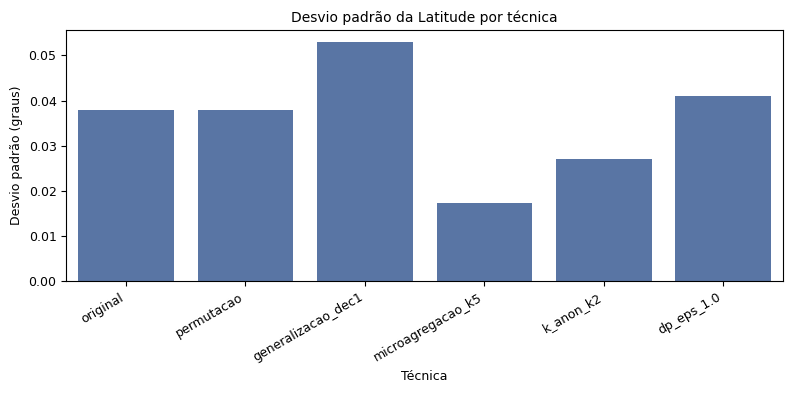

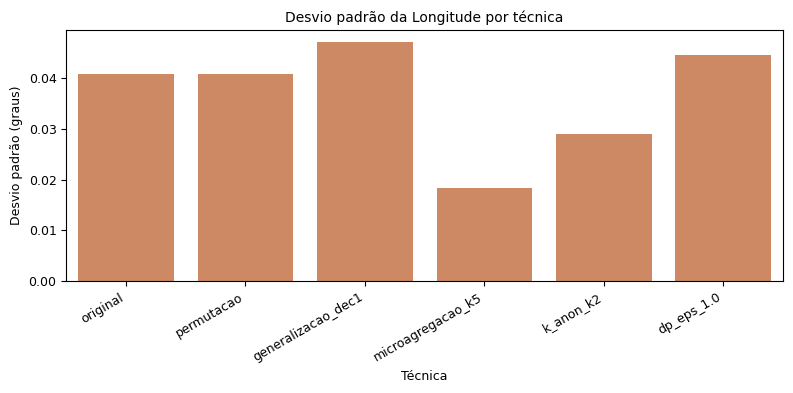

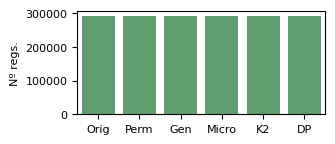

In [51]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=df_resumo,
    x="tecnica",
    y="lat_std",
    color="#4c72b0"
)
plt.xticks(rotation=30, ha="right")
plt.title("Desvio padrão da Latitude por técnica")
plt.ylabel("Desvio padrão (graus)")
plt.xlabel("Técnica")
plt.tight_layout()
plt.savefig(f"{OUT_FIG}/std_latitude.png", dpi=250)
plt.show()


plt.figure(figsize=(8, 4))
sns.barplot(
    data=df_resumo,
    x="tecnica",
    y="lon_std",
    color="#dd8452"
)
plt.xticks(rotation=30, ha="right")
plt.title("Desvio padrão da Longitude por técnica")
plt.ylabel("Desvio padrão (graus)")
plt.xlabel("Técnica")
plt.tight_layout()
plt.savefig(f"{OUT_FIG}/std_longitude.png", dpi=250)
plt.show()

# Quantidade de resgistros analisados
map_labels = {
    "original": "Orig",
    "permutacao": "Perm",
    "generalizacao_dec1": "Gen",
    "microagregacao_k5": "Micro",
    "k_anon_k2": "K2",
    "dp_eps_1.0": "DP"
}

df_plot = df_resumo.copy()
df_plot["tecnica_short"] = df_plot["tecnica"].map(map_labels)

plt.figure(figsize=(3.2, 1.3))  # bem baixa, 1 coluna
sns.barplot(data=df_plot, x="tecnica_short", y="n_pontos", color="#55a868")
plt.ylabel("Nº regs.", fontsize=8)
plt.xlabel("")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout(pad=0.2)
plt.savefig(f"{OUT_FIG}/fig1_nregs_compact.png", dpi=300, bbox_inches="tight", pad_inches=0.02)
plt.show()



In [60]:
# gerar_figuras_artigo.py
import os
import math
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch
from sklearn.neighbors import BallTree


# =========================
# 1) CONFIGURAÇÃO GLOBAL (UMA VEZ SÓ)
# =========================
def set_paper_style():
    """Padroniza fontes/linhas para todas as figuras (estilo paper)."""
    mpl.rcParams.update({
        # fontes
        "font.size": 10,
        "axes.titlesize": 10,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "legend.title_fontsize": 10,

        # linhas e estética
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.5,
        "lines.linewidth": 1.2,

        # export
        "savefig.dpi": 300,
    })
    sns.set_style("whitegrid")


def save_fig(fig, out_path: str):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    fig.savefig(out_path, dpi=300, bbox_inches="tight", pad_inches=0.02)
    plt.close(fig)
    print("✅ Salvo:", out_path)


# Tamanhos típicos
FIG_W_1COL = 3.4   # ~ largura de 1 coluna
FIG_W_2COL = 6.8   # ~ largura de 2 colunas


# =========================
# 2) PATHS (AJUSTE AQUI)
# =========================
BASE_ANON = "/content/drive/MyDrive/Mestrado/Artigo - Dados/Dados_Anonimizados"
BASE_OUT = "/content/drive/MyDrive/Mestrado/Artigo - Dados/Ataques_Resultados"
OUT_FIG  = "/content/drive/MyDrive/Mestrado/Artigo - Dados/figures"

TECNICAS = {
    "original": f"{BASE_ANON}/original",
    "permutacao": f"{BASE_ANON}/permutacao",
    "generalizacao_dec1": f"{BASE_ANON}/generalizacao_dec1",
    "microagregacao_k5": f"{BASE_ANON}/microagregacao_k5",
    "k_anon_k2": f"{BASE_ANON}/k_anon_k2",
    "dp_eps_1.0": f"{BASE_ANON}/dp/eps_1.0",
}

MAP_LABELS = {
    "original": "Orig",
    "permutacao": "Perm",
    "generalizacao_dec1": "Gen",
    "microagregacao_k5": "Micro",
    "k_anon_k2": "K2",
    "dp_eps_1.0": "DP",
}


# =========================
# 3) FUNÇÕES AUXILIARES DE DADOS
# =========================
def carregar_tecnica(pasta_tecnica, anos=None):
    """Carrega CSVs (se houver um por ano, concatena). Se anos=None, tenta todos CSVs."""
    paths = []
    if anos:
        for ano in anos:
            candidatos = glob.glob(os.path.join(pasta_tecnica, f"*{ano}*.csv"))
            if not candidatos:
                raise FileNotFoundError(f"❌ Não achei CSV do ano {ano} em: {pasta_tecnica}")
            paths.append(candidatos[0])
    else:
        paths = sorted(glob.glob(os.path.join(pasta_tecnica, "*.csv")))
        if not paths:
            raise FileNotFoundError(f"❌ Não achei CSV em: {pasta_tecnica}")

    dfs = [pd.read_csv(p, low_memory=False) for p in paths]
    return pd.concat(dfs, ignore_index=True)


def preparar_df_coords(df):
    out = df.copy()
    if "inspection_realized_at" in out.columns:
        out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")

    out["latitude"] = pd.to_numeric(out["latitude"], errors="coerce")
    out["longitude"] = pd.to_numeric(out["longitude"], errors="coerce")
    out = out.dropna(subset=["latitude", "longitude"])

    # filtro geográfico (POA) - ajuste se necessário
    out = out[
        out["latitude"].between(-30.20, -29.80) &
        out["longitude"].between(-51.35, -50.95)
    ].copy()
    return out


def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0
    lat1 = np.deg2rad(lat1); lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2); lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c


# =========================
# 4) FIGURA 1 — Nº REGISTROS (compacta)
# =========================
def fig1_n_registros(df_resumo: pd.DataFrame):
    df_plot = df_resumo.copy()
    df_plot["tecnica_short"] = df_plot["tecnica"].map(MAP_LABELS)

    fig, ax = plt.subplots(figsize=(FIG_W_1COL, 2.0))

    sns.barplot(data=df_plot, x="tecnica_short", y="n_pontos", color="#55a868", ax=ax)

    ax.set_title("Quantidade de registros analisados", pad=6)
    ax.set_xlabel("")
    ax.set_ylabel("Nº registros (×10³)")

    # reescala (milhares) no tick, mantendo valores no dataset
    ax.yaxis.set_major_locator(MaxNLocator(4))
    ax.yaxis.set_major_formatter(lambda x, _: f"{x/1000:.0f}")

    ax.grid(axis="y", alpha=0.25)
    ax.grid(axis="x", visible=False)

    fig.tight_layout(pad=0.2)
    save_fig(fig, os.path.join(OUT_FIG, "fig1_n_registros.png"))


# =========================
# 5) FIGURA 2 — TRADE-OFF AUC vs RECALL
# (assume df_metricas com colunas: AUC_ROC, Recall_Surto, tecnica)
# =========================
def fig2_tradeoff_auc_recall(path_df_metricas: str):
    df = pd.read_csv(path_df_metricas)

    fig, ax = plt.subplots(figsize=(FIG_W_1COL, 2.2))
    sns.scatterplot(
        data=df,
        x="AUC_ROC",
        y="Recall_Surto",
        hue="tecnica",
        s=55,
        ax=ax
    )

    ax.set_title("Trade-off: AUC vs Recall", pad=6)
    ax.set_xlabel("AUC-ROC")
    ax.set_ylabel("Recall")
    ax.grid(True, alpha=0.25)

    # legenda compacta fora
    ax.legend(
        title="Técnica",
        loc="upper left",
        bbox_to_anchor=(1.02, 1),
        frameon=True,
        ncol=1
    )

    fig.tight_layout(pad=0.2)
    save_fig(fig, os.path.join(OUT_FIG, "fig2_tradeoff_auc_recall.png"))


# =========================
# 6) FIGURA 3 — std lat/lon (2 painéis)
# =========================
def fig3_std_lat_lon(df_resumo: pd.DataFrame):
    df_plot = df_resumo.copy()
    df_plot["tecnica_short"] = df_plot["tecnica"].map(MAP_LABELS)

    fig, axs = plt.subplots(1, 2, figsize=(FIG_W_2COL, 2.2))

    sns.barplot(data=df_plot, x="tecnica_short", y="lat_std", color="#4c72b0", ax=axs[0])
    sns.barplot(data=df_plot, x="tecnica_short", y="lon_std", color="#dd8452", ax=axs[1])

    axs[0].set_title("Desvio padrão da Latitude", pad=6)
    axs[1].set_title("Desvio padrão da Longitude", pad=6)

    for ax in axs:
        ax.set_xlabel("")
        ax.set_ylabel("Std (graus)")
        ax.yaxis.set_major_locator(MaxNLocator(4))
        ax.grid(axis="y", alpha=0.25)
        ax.grid(axis="x", visible=False)

    fig.tight_layout(pad=0.3)
    save_fig(fig, os.path.join(OUT_FIG, "fig3_std_lat_lon.png"))


# =========================
# 7) FIGURA 5 — A3 Ambiguidade (raio 200m) com legenda correta
# =========================
def fig5_a3_ambiguidade(path_a3: str, raio_m: int = 200):
    df = pd.read_csv(path_a3)
    d = df[df["radius_m"] == raio_m].copy()
    d = d.sort_values("avg_candidates", ascending=False)

    order = d["tecnica"].tolist()
    colors = sns.color_palette("tab10", n_colors=len(order))
    palette = dict(zip(order, colors))

    fig, ax = plt.subplots(figsize=(FIG_W_2COL, 2.2))

    # plota sem hue e pinta manual (mais robusto)
    sns.barplot(
        data=d,
        x="tecnica",
        y="avg_candidates",
        order=order,
        color="lightgray",
        ax=ax
    )
    for bar, tech in zip(ax.patches, order):
        bar.set_facecolor(palette[tech])
        bar.set_edgecolor("none")

    handles = [Patch(facecolor=palette[t], label=t) for t in order]
    ax.legend(
        handles=handles,
        title="Técnica",
        loc="upper left",
        bbox_to_anchor=(1.02, 1),
        frameon=True,
        ncol=1
    )

    ax.set_title(f"A3: Ambiguidade (raio {raio_m} m)", pad=6)
    ax.set_xlabel("")
    ax.set_ylabel("Média de candidatos")
    ax.set_xticklabels([])  # nomes vão pra legenda
    ax.tick_params(axis="x", length=0)

    ax.yaxis.set_major_locator(MaxNLocator(4))
    ax.grid(axis="y", alpha=0.25)
    ax.grid(axis="x", visible=False)

    fig.tight_layout(pad=0.2)
    save_fig(fig, os.path.join(OUT_FIG, "fig5_a3_ambiguidade.png"))


# =========================
# 8) FIGURA 4 — A1/A2 (curvas)
# (usa csv consolidado A1 e A2 gerado no seu pipeline)
# =========================
def fig4_a1_a2(path_a1: str, path_a2: str):
    df_a1 = pd.read_csv(path_a1)
    df_a2 = pd.read_csv(path_a2)

    fig, axs = plt.subplots(1, 2, figsize=(FIG_W_2COL, 2.6))

    sns.lineplot(
        data=df_a1, x="leak_rate", y="reid_rate",
        hue="radius_m", style="tecnica", markers=True, ax=axs[0]
    )
    axs[0].set_title("A1 (NN-Linkage)", pad=6)
    axs[0].set_xlabel("Vazamento")
    axs[0].set_ylabel("Taxa reidentificação")
    axs[0].grid(True, alpha=0.25)
    axs[0].legend(title="raio / técnica", frameon=True)

    sns.lineplot(
        data=df_a2, x="leak_rate", y="hit_rate",
        hue="topk", style="tecnica", markers=True, ax=axs[1]
    )
    axs[1].set_title("A2 (Top-K)", pad=6)
    axs[1].set_xlabel("Vazamento")
    axs[1].set_ylabel("Taxa de sucesso")
    axs[1].grid(True, alpha=0.25)
    axs[1].legend(title="k / técnica", frameon=True)

    fig.tight_layout(pad=0.3)
    save_fig(fig, os.path.join(OUT_FIG, "fig4_a1_a2.png"))


# =========================
# 9) MAIN — gera tudo
# =========================
def main():
    set_paper_style()
    os.makedirs(OUT_FIG, exist_ok=True)

    # --- (A) carrega datasets das técnicas para resumo espacial (std lat/lon e n_pontos)
    # Se você já tem df_resumo salvo, pode ler de csv aqui.
    dfs = {}
    for tecnica, path in TECNICAS.items():
        df_raw = carregar_tecnica(path, anos=[2018, 2019, 2020, 2021, 2022, 2023])
        dfs[tecnica] = preparar_df_coords(df_raw)

    def resumo_espacial(df_, tecnica_):
        return {
            "tecnica": tecnica_,
            "lat_std": float(df_["latitude"].std()),
            "lon_std": float(df_["longitude"].std()),
            "n_pontos": int(len(df_))
        }

    resumos = [resumo_espacial(dfs[t], t) for t in TECNICAS.keys()]
    df_resumo = pd.DataFrame(resumos)

    # --- (B) Figuras
    fig1_n_registros(df_resumo)
    fig3_std_lat_lon(df_resumo)

    # Ajuste estes paths conforme seus arquivos consolidados:
    path_metricas = os.path.join(BASE_OUT, "metricas_modelos.csv")  # <- se existir
    if os.path.exists(path_metricas):
        fig2_tradeoff_auc_recall(path_metricas)
    else:
        print("⚠️ Pulando Fig. 2: não encontrei", path_metricas)

    path_a1 = os.path.join(BASE_OUT, "A1_nn_linkage_curve_todas.csv")
    path_a2 = os.path.join(BASE_OUT, "A2_topk_curve_todas.csv")
    if os.path.exists(path_a1) and os.path.exists(path_a2):
        fig4_a1_a2(path_a1, path_a2)
    else:
        print("⚠️ Pulando Fig. 4: faltam A1/A2 consolidados:", path_a1, path_a2)

    path_a3 = os.path.join(BASE_OUT, "A3_ambiguidade_todas_tecnicas.csv")
    if os.path.exists(path_a3):
        fig5_a3_ambiguidade(path_a3, raio_m=200)
    else:
        print("⚠️ Pulando Fig. 5: não encontrei", path_a3)

    print("\n✅ Finalizado. Figuras em:", OUT_FIG)


if __name__ == "__main__":
    main()


/tmp/ipython-input-1578896212.py:104: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")
/tmp/ipython-input-1578896212.py:104: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")


✅ Salvo: /content/drive/MyDrive/Mestrado/Artigo - Dados/figures/fig1_n_registros.png
✅ Salvo: /content/drive/MyDrive/Mestrado/Artigo - Dados/figures/fig3_std_lat_lon.png
⚠️ Pulando Fig. 2: não encontrei /content/drive/MyDrive/Mestrado/Artigo - Dados/Ataques_Resultados/metricas_modelos.csv
✅ Salvo: /content/drive/MyDrive/Mestrado/Artigo - Dados/figures/fig4_a1_a2.png
✅ Salvo: /content/drive/MyDrive/Mestrado/Artigo - Dados/figures/fig5_a3_ambiguidade.png

✅ Finalizado. Figuras em: /content/drive/MyDrive/Mestrado/Artigo - Dados/figures


In [1]:
# ==========================================
# gerar_figuras_padronizadas.py
# - padroniza fontes (igual trade-off)
# - adiciona rótulos nas barras
# - mantém formato das figuras 6 e 7, só aumenta fonte
# ==========================================

import os
import math
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch
from sklearn.neighbors import BallTree

# =========================
# 1) CONFIG GLOBAL (UMA VEZ)
# =========================

# Ajuste aqui para ficar igual ao trade-off do seu notebook
BASE_FONT = 11  # <-- se quiser maior, use 12; se quiser menor, 10

def set_paper_style(base_font: int = BASE_FONT):
    """Padroniza fontes/linhas para todas as figuras."""
    mpl.rcParams.update({
        # fontes
        "font.size": base_font,
        "axes.titlesize": base_font + 1,
        "axes.labelsize": base_font,
        "xtick.labelsize": base_font,
        "ytick.labelsize": base_font,
        "legend.fontsize": base_font,
        "legend.title_fontsize": base_font,

        # estética
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.5,
        "lines.linewidth": 1.2,

        # export
        "savefig.dpi": 300,
    })
    sns.set_style("whitegrid")

def save_fig(fig, out_path: str, tight: bool = True):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    if tight:
        fig.savefig(out_path, dpi=300, bbox_inches="tight", pad_inches=0.02)
    else:
        fig.savefig(out_path, dpi=300)
    plt.close(fig)
    print("✅ Salvo:", out_path)

def add_bar_labels(ax, fmt="{:.0f}", padding=2, fontsize=None):
    """Escreve o valor em cima de cada barra (funciona para barplot do seaborn)."""
    if fontsize is None:
        fontsize = mpl.rcParams["font.size"]

    for p in ax.patches:
        h = p.get_height()
        if np.isnan(h):
            continue
        ax.annotate(
            fmt.format(h),
            (p.get_x() + p.get_width() / 2.0, h),
            ha="center",
            va="bottom",
            xytext=(0, padding),
            textcoords="offset points",
            fontsize=fontsize
        )

# Tamanhos típicos (ajuste conforme o template SBRC)
FIG_W_1COL = 3.2   # ~ 1 coluna
FIG_W_2COL = 6.6   # ~ 2 colunas

# =========================
# 2) PATHS (AJUSTE AQUI)
# =========================
BASE_ANON = "/content/drive/MyDrive/Mestrado/Artigo - Dados/Dados_Anonimizados"
BASE_OUT  = "/content/drive/MyDrive/Mestrado/Artigo - Dados/Ataques_Resultados"
OUT_FIG   = "/content/drive/MyDrive/Mestrado/Artigo - Dados/figures"

TECNICAS = {
    "original": f"{BASE_ANON}/original",
    "permutacao": f"{BASE_ANON}/permutacao",
    "generalizacao_dec1": f"{BASE_ANON}/generalizacao_dec1",
    "microagregacao_k5": f"{BASE_ANON}/microagregacao_k5",
    "k_anon_k2": f"{BASE_ANON}/k_anon_k2",
    "dp_eps_1.0": f"{BASE_ANON}/dp/eps_1.0",
}

MAP_LABELS = {
    "original": "Orig",
    "permutacao": "Perm",
    "generalizacao_dec1": "Gen",
    "microagregacao_k5": "Micro",
    "k_anon_k2": "K2",
    "dp_eps_1.0": "DP",
}

# =========================
# 3) FUNÇÕES DE DADOS
# =========================
ANOS = [2018, 2019, 2020, 2021, 2022, 2023]

def carregar_tecnica(pasta_tecnica: str, anos=None) -> pd.DataFrame:
    """Carrega CSVs; se anos informado, busca um CSV por ano; senão concatena todos os CSVs."""
    paths = []
    if anos:
        for ano in anos:
            candidatos = glob.glob(os.path.join(pasta_tecnica, f"*{ano}*.csv"))
            if not candidatos:
                raise FileNotFoundError(f"❌ Não achei CSV do ano {ano} em: {pasta_tecnica}")
            paths.append(candidatos[0])
    else:
        paths = sorted(glob.glob(os.path.join(pasta_tecnica, "*.csv")))
        if not paths:
            raise FileNotFoundError(f"❌ Não achei CSV em: {pasta_tecnica}")

    dfs = [pd.read_csv(p, low_memory=False) for p in paths]
    return pd.concat(dfs, ignore_index=True)

def preparar_df_coords(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if "inspection_realized_at" in out.columns:
        out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")

    out["latitude"] = pd.to_numeric(out["latitude"], errors="coerce")
    out["longitude"] = pd.to_numeric(out["longitude"], errors="coerce")
    out = out.dropna(subset=["latitude", "longitude"])

    # filtro geográfico (POA) - ajuste se necessário
    out = out[
        out["latitude"].between(-30.20, -29.80) &
        out["longitude"].between(-51.35, -50.95)
    ].copy()

    return out

def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0
    lat1 = np.deg2rad(lat1); lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2); lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# =========================
# 4) FIGURAS DE BARRA (COM RÓTULO)
# =========================

def fig_bar_std_lat_lon(df_resumo: pd.DataFrame):
    dfp = df_resumo.copy()
    dfp["tecnica_short"] = dfp["tecnica"].map(MAP_LABELS)

    fig, axs = plt.subplots(1, 2, figsize=(FIG_W_2COL, 2.4))

    sns.barplot(data=dfp, x="tecnica_short", y="lat_std", color="#4c72b0", ax=axs[0])
    sns.barplot(data=dfp, x="tecnica_short", y="lon_std", color="#dd8452", ax=axs[1])

    axs[0].set_title("Desvio padrão da Latitude", pad=6)
    axs[1].set_title("Desvio padrão da Longitude", pad=6)

    for ax in axs:
        ax.set_xlabel("")
        ax.set_ylabel("Std (graus)")
        ax.yaxis.set_major_locator(MaxNLocator(4))
        ax.grid(axis="y", alpha=0.25)
        ax.grid(axis="x", visible=False)
        add_bar_labels(ax, fmt="{:.3f}", padding=2)

    fig.tight_layout(pad=0.3)
    save_fig(fig, os.path.join(OUT_FIG, "fig_std_lat_lon.png"))

def fig_bar_n_registros(df_resumo: pd.DataFrame):
    dfp = df_resumo.copy()
    dfp["tecnica_short"] = dfp["tecnica"].map(MAP_LABELS)

    fig, ax = plt.subplots(figsize=(FIG_W_1COL, 2.1))
    sns.barplot(data=dfp, x="tecnica_short", y="n_pontos", color="#55a868", ax=ax)

    ax.set_title("Quantidade de registros analisados", pad=6)
    ax.set_xlabel("")
    ax.set_ylabel("Nº registros (×10³)")
    ax.yaxis.set_major_locator(MaxNLocator(4))

    # ticks em milhares (sem mudar os dados)
    ax.yaxis.set_major_formatter(lambda x, _: f"{x/1000:.0f}")
    ax.grid(axis="y", alpha=0.25)
    ax.grid(axis="x", visible=False)

    # rótulo em milhares também
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(
            f"{h/1000:.0f}",
            (p.get_x() + p.get_width()/2, h),
            ha="center", va="bottom",
            xytext=(0, 2),
            textcoords="offset points",
            fontsize=mpl.rcParams["font.size"]
        )

    fig.tight_layout(pad=0.2)
    save_fig(fig, os.path.join(OUT_FIG, "fig_n_registros.png"))

# =========================
# 5) FIGURA TRADE-OFF (MESMO TAMANHO DO NOTEBOOK ORIGINAL)
# =========================

def fig_tradeoff_auc_recall(path_metricas_csv: str):
    dfm = pd.read_csv(path_metricas_csv)

    # tamanho igual ao que você mostrou: figsize=(6,2) (trade-off)
    fig, ax = plt.subplots(figsize=(6, 2))

    sns.scatterplot(
        data=dfm,
        x="Recall_Surto",
        y="AUC_ROC",
        hue="tecnica",
        s=100,
        ax=ax
    )

    ax.set_title("Trade-off: Discriminação (AUC) vs Detecção de Surto (Recall)", pad=6)
    ax.set_xlabel("Recall_Surto")
    ax.set_ylabel("AUC_ROC")
    ax.grid(True, alpha=0.3)

    # legenda fora (como no original)
    ax.legend(
        title=None,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        frameon=True
    )

    fig.tight_layout(pad=0.2)
    save_fig(fig, os.path.join(OUT_FIG, "fig_tradeoff_auc_recall.png"))

# =========================
# 6) FIGURA 6 — MAPA DE CALOR 3x2 (MANTÉM FORMATO, SÓ AUMENTA FONTE)
# =========================

def fig6_mapa_calor_dist_norm(
    df_original: pd.DataFrame,
    sample: int = 12000,
    out_name: str = "fig6_mapa_calor_dist_norm_3x2.png",
):
    mapas = [
        ("original", "Original (referência)"),
        ("dp_eps_1.0", "Privacidade Diferencial (ε = 1.0)"),
        ("generalizacao_dec1", "Generalização"),
        ("k_anon_k2", "k-anonimato (k = 2)"),
        ("microagregacao_k5", "Microagregação (k = 5)"),
        ("permutacao", "Permutação"),
    ]

    # limites fixos (mantém comparabilidade)
    lat_min, lat_max = -30.20, -29.95
    lon_min, lon_max = -51.30, -51.05

    rng = np.random.default_rng(42)

    def dist_norm_por_tecnica(df_orig, df_anon):
        n = min(len(df_orig), len(df_anon))
        o = df_orig.iloc[:n][["latitude", "longitude"]].to_numpy()
        a = df_anon.iloc[:n][["latitude", "longitude"]].to_numpy()

        d = haversine_m(o[:, 0], o[:, 1], a[:, 0], a[:, 1])
        d_min = float(np.min(d))
        d_max = float(np.max(d))
        if d_max == d_min:
            d_norm = np.zeros_like(d, dtype=float)
        else:
            d_norm = (d - d_min) / (d_max - d_min)
        return d_norm, d_min, d_max, n

    fig, axes = plt.subplots(2, 3, figsize=(9.5, 6.2), sharex=True, sharey=True)

    sc = None
    for ax, (tecnica, titulo) in zip(axes.flatten(), mapas):
        if tecnica == "original":
            df = df_original.copy()
            n = len(df)
            d_norm = np.zeros(n, dtype=float)
            d_min, d_max = 0.0, 0.0
        else:
            df_raw = carregar_tecnica(TECNICAS[tecnica], anos=ANOS)
            df = preparar_df_coords(df_raw)

            d_norm, d_min, d_max, n = dist_norm_por_tecnica(df_original, df)
            df = df.iloc[:n].copy()

        if len(df) > sample:
            idx = rng.choice(len(df), size=sample, replace=False)
            df_plot = df.iloc[idx]
            c = d_norm[idx]
        else:
            df_plot = df
            c = d_norm

        sc = ax.scatter(
            df_plot["longitude"],
            df_plot["latitude"],
            c=c,
            s=3,
            alpha=0.55,
            cmap="RdYlGn"
        )

        ax.set_title(titulo, pad=6)  # fonte já vem do rcParams
        ax.set_xlim(lon_min, lon_max)
        ax.set_ylim(lat_min, lat_max)
        ax.grid(True, alpha=0.3)

        ax.text(
            0.02, 0.98,
            f"min={d_min:.1f}m\nmax={d_max:.1f}m",
            transform=ax.transAxes,
            va="top", ha="left",
            fontsize=mpl.rcParams["font.size"],  # cresce junto
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
        )

    fig.supxlabel("Longitude")
    fig.supylabel("Latitude")

    # colorbar única (mantém o mesmo layout!)
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc, cax=cax)
    cbar.set_label("Distância normalizada\n(0 = menor, 1 = maior)")
    cbar.ax.tick_params(labelsize=mpl.rcParams["ytick.labelsize"])

    plt.tight_layout(rect=[0, 0, 0.90, 0.95])
    save_fig(fig, os.path.join(OUT_FIG, out_name), tight=False)

# =========================
# 7) FIGURA 7 — HISTOGRAMA 3x2 (MANTÉM FORMATO, SÓ AUMENTA FONTE)
# =========================

def fig7_hist_dist_uniforme(
    df_original: pd.DataFrame,
    n_barras: int = 30,
    y_step: int = 20000,
    out_name: str = "fig7_hist_dist_uniforme_30bins_mesma_escalaY.png",
):
    mapas = [
        ("_vazio_", " "),
        ("dp_eps_1.0", "Privacidade Diferencial (ε = 1.0)"),
        ("generalizacao_dec1", "Generalização"),
        ("k_anon_k2", "k-anonimato (k = 2)"),
        ("microagregacao_k5", "Microagregação (k = 5)"),
        ("permutacao", "Permutação"),
    ]

    def dist_m_por_tecnica(df_orig, df_anon):
        n = min(len(df_orig), len(df_anon))
        o = df_orig.iloc[:n][["latitude", "longitude"]].to_numpy()
        a = df_anon.iloc[:n][["latitude", "longitude"]].to_numpy()
        return haversine_m(o[:, 0], o[:, 1], a[:, 0], a[:, 1])

    dist_por_tecnica = {}
    y_max_global = 0

    for tecnica, _ in mapas:
        if tecnica == "_vazio_":
            continue
        df_raw = carregar_tecnica(TECNICAS[tecnica], anos=ANOS)
        df_anon = preparar_df_coords(df_raw)

        d = dist_m_por_tecnica(df_original, df_anon)
        dist_por_tecnica[tecnica] = d
        y_max_global = max(y_max_global, np.histogram(d, bins=n_barras)[0].max())

    y_max_global = int(math.ceil(y_max_global / y_step) * y_step)

    fig, axes = plt.subplots(2, 3, figsize=(11.5, 6.5), sharey=True)

    for ax, (tecnica, titulo) in zip(axes.flatten(), mapas):
        if tecnica == "_vazio_":
            ax.axis("off")
            continue

        d = dist_por_tecnica[tecnica]
        d_min = float(d.min())
        d_max = float(d.max())
        med = float(np.median(d))

        if d_max == d_min:
            bins = np.linspace(d_min, d_min + 1e-6, n_barras + 1)
        else:
            bins = np.linspace(d_min, d_max, n_barras + 1)

        ax.hist(d, bins=bins, color="#4c72b0", alpha=0.9, edgecolor="white", linewidth=0.4)

        ax.set_title(titulo, pad=6)
        ax.set_xlabel("Distância (m)")
        ax.set_ylabel("Contagem")
        ax.set_ylim(0, y_max_global)
        ax.grid(True, axis="y", alpha=0.3)

        ax.text(
            0.98, 0.98,
            f"min={d_min:.2f}m\nmed={med:.2f}m\nmax={d_max:.1f}m",
            transform=ax.transAxes,
            ha="right", va="top",
            fontsize=mpl.rcParams["font.size"],
            bbox=dict(facecolor="white", alpha=0.75, edgecolor="none")
        )

    plt.tight_layout()
    save_fig(fig, os.path.join(OUT_FIG, out_name))

# =========================
# 8) MAIN
# =========================

def main():
    set_paper_style(BASE_FONT)

    # Carrega todas as técnicas para resumo e para as figs 6/7
    dfs = {}
    for tecnica, path in TECNICICAS.items() if False else TECNICAS.items():
        df_raw = carregar_tecnica(path, anos=ANOS)
        dfs[tecnica] = preparar_df_coords(df_raw)

    df_original = dfs["original"]

    # resumo espacial (para barras)
    def resumo_espacial(df_, tecnica_):
        return {
            "tecnica": tecnica_,
            "lat_std": float(df_["latitude"].std()),
            "lon_std": float(df_["longitude"].std()),
            "n_pontos": int(len(df_)),
        }

    df_resumo = pd.DataFrame([resumo_espacial(dfs[t], t) for t in TECNICAS.keys()])

    # ---- Figuras de barra (com rótulos)
    fig_bar_n_registros(df_resumo)
    fig_bar_std_lat_lon(df_resumo)

    # ---- Trade-off (tamanho igual ao original)
    # ajuste o path do CSV de métricas (o seu "tabela_metricas_todas_tecnicas.csv" serve)
    metricas_csv = "/content/drive/MyDrive/Mestrado/Artigo - Dados/Comparacao_Final/tabela_metricas_todas_tecnicas.csv"
    if os.path.exists(metricas_csv):
        fig_tradeoff_auc_recall(metricas_csv)
    else:
        print("⚠️ Não achei métricas em:", metricas_csv)

    # ---- Figuras 6 e 7 (mantém formato; aumenta só fontes via set_paper_style)
    fig6_mapa_calor_dist_norm(df_original)
    fig7_hist_dist_uniforme(df_original)

    print("\n✅ Finalizado. Figuras em:", OUT_FIG)

if __name__ == "__main__":
    main()


/tmp/ipython-input-929602087.py:132: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")
/tmp/ipython-input-929602087.py:132: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")


✅ Salvo: /content/drive/MyDrive/Mestrado/Artigo - Dados/figures/fig_n_registros.png
✅ Salvo: /content/drive/MyDrive/Mestrado/Artigo - Dados/figures/fig_std_lat_lon.png
✅ Salvo: /content/drive/MyDrive/Mestrado/Artigo - Dados/figures/fig_tradeoff_auc_recall.png


/tmp/ipython-input-929602087.py:132: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")
/tmp/ipython-input-929602087.py:132: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")
/tmp/ipython-input-929602087.py:344: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 0.95])


✅ Salvo: /content/drive/MyDrive/Mestrado/Artigo - Dados/figures/fig6_mapa_calor_dist_norm_3x2.png


/tmp/ipython-input-929602087.py:132: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")
/tmp/ipython-input-929602087.py:132: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["inspection_realized_at"] = pd.to_datetime(out["inspection_realized_at"], errors="coerce")


✅ Salvo: /content/drive/MyDrive/Mestrado/Artigo - Dados/figures/fig7_hist_dist_uniforme_30bins_mesma_escalaY.png

✅ Finalizado. Figuras em: /content/drive/MyDrive/Mestrado/Artigo - Dados/figures
